# **Waves of Whimsy**
*Sanvi Nagaraj, Henna Patel, Lux Morgan*

In [50]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### ***Fitting the Oscillatory Function to Data & Plotting It***

Best fit parameters:
offset  = 2.5238 ± 0.0323
A1      = 1.0135 ± 0.1151
phi1    = -0.0428 ± 0.0751
A2      = 2.6720 ± 0.0784
phi2    = 1.8516 ± 0.0254


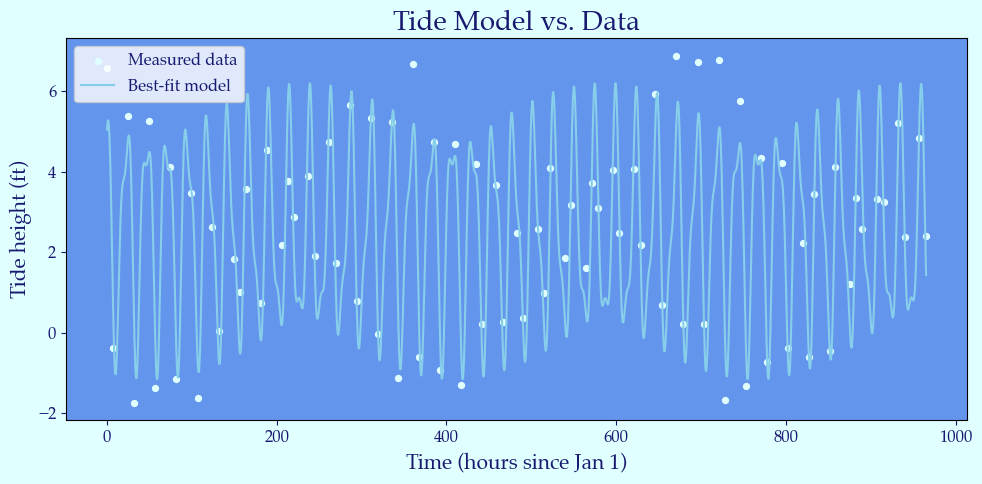

In [51]:
#basically a chunk of text, need everything as a string cuz it was having trouble reading it
raw_data = """ 
1  8:07  6.57
1 15:37 -0.39
2  8:55  5.38
2 16:25 -1.74
3  9:45  5.26
3 17:14 -1.36
4 10:35  4.13
4 18:00 -1.15
5 11:28  3.48
5 18:46 -1.61
6 12:22  2.62
6 19:31  0.05
7 13:24  1.83
7 20:16  1.01
8  3:22  3.57
8 21:01  0.73
9  4:07  4.54
9 21:46  2.17
10  4:50  3.76
10 11:58  2.88
11  5:31  3.90
11 12:56  1.92
12  6:08  4.73
12 13:45  1.74
13  6:47  5.66
13 14:25  0.79
14  7:22  5.33
14 15:00 -0.04
15  7:59  5.23
15 15:34 -1.12
16  8:34  6.67
16 16:08 -0.61
17  9:10  4.74
17 16:41 -0.93
18  9:45  4.69
18 17:12 -1.29
19 10:21  4.20
19 17:45  0.22
20 10:57  3.68
20 18:15  0.26
21 11:38  2.47
21 18:48  0.36
22 12:25  2.59
22 19:20  0.99
23  2:22  4.10
23 19:52  1.87
24  2:58  3.17
24 20:30  1.60
25  3:37  3.71
25 10:44  3.10
26  4:23  4.04
26 11:55  2.49
27  5:15  4.07
27 12:57  2.18
28  6:09  5.93
28 13:50  0.70
29  7:05  6.89
29 14:39  0.21
30  7:58  6.72
30 15:27  0.22
31  8:50  6.77
31 16:10 -1.68
32  9:40  5.77
32 16:52 -1.32
33 10:30  4.35
33 17:34 -0.73
34 11:19  4.23
34 18:12 -0.38
35 12:10  2.24
35 18:49 -0.61
36  1:32  3.45
36 19:24 -0.46
37  2:13  4.13
37 20:00  1.21
38  2:54  3.34
38  9:54  2.58
39  3:39  3.32
39 11:15  3.26
40  4:29  5.21
40 12:22  2.39
41  5:21  4.83
41 13:14  2.41
"""

rows = [] #make an empt list so evrything in it is tuple
for line in raw_data.strip().split("\n"): #for loop goes through eachline at time (in raw_data), takes out empt space &splits the text into lines
    parts = line.split() #split line by spaces into string list
    if len(parts) != 3:
        print("Skipping malformed line:", line)
        continue
    day, t, h = parts #sorts elelments in list into dif variables
    day = int(day) #need to convert day from string to integer
    height = float(h) #need to convert tide from string to float
    hour, minute = map(int, t.split(":")) #split hour abd minute into 2, colon indicates where to split
    dt = datetime(2022, 1, 1) + timedelta(days=day-1, hours=hour, minutes=minute) #datetime object for this tide measurement: starts at Jan 1, 2022, 00:00
    rows.append((dt, height)) #dt = exact timestamp of this measurement, adds tuple (datetime, tide_height) to the rows list
    #after the loop, rows contains all parsed data ready for plotting or analysis

df = pd.DataFrame(rows, columns=["datetime", "height"]) #rows is the list of tuples built earlier: (datetime, height)
#pd.DataFrame() converts it into a pandas DataFrame (is a tabular data structure (like a spreadsheet) that is easier to work with)
#columns=["datetime", "height"] names the two columns
#resulting dataFrame (df) looks like:
#datetime	height
#2022-01-01 08:07	6.57
#2022-01-01 15:37	-0.39

# Convert to hours since Jan 1
t0 = df["datetime"].min() #need to find earliest timestamp, defines it as the lowest #
df["t_hours"] = (df["datetime"] - t0).dt.total_seconds() / 3600 
# calculates the time difference between each measurement and the start, return timedelta object, convert time difference to seconds, 
#then hrs, stores result in t_hours

# Two major tidal components: semidiurnal and diurnal
P1 = 12.4206   # semidiurnal in hours (2 high 2 low)
P2 = 24.0000   # diurnal (1 high 1 low)

# function models the tide as a sum of two oscillating components
def model(t, offset, A1, phi1, A2, phi2):
    return (offset +
            A1 * np.sin(2*np.pi*t/P1 + phi1) +
            A2 * np.sin(2*np.pi*t/P2 + phi2))
# t = time in hrs
# offset = average tide height
# A1 = amp of semidurnal
# phi1 = phase of semidurnal (shifts the wave with time)
# A2 = amp of durnal
# phi2 =n phase of durnal (shifts the wave wiht time)

t = df["t_hours"].values #extract the time values as numpy array
y = df["height"].values #extract the tide heights as numpy array
sigma = np.full_like(y, 0.25) #make an array same amount of values of height, but filled with 0.25, tells the fitting algorithm that
#each tide height measurement accurate to ±0.25 feet, 
#curve fitting func decides how much to trust each data point when building the best fitting tidal curve 

p0 = [2.5, 1.0, 0, 2.0, 0]  # initial guesses
#(offest, A1, phi1, A2, phi2)

popt, pcov = curve_fit(model, t, y, sigma=sigma, absolute_sigma=True, p0=p0) #best fit curve using non linear least squares
perr = np.sqrt(np.diag(pcov))

#sigma=sigma gives the error for each measurement
#absolute_sigma=True tells curve_fit to treat sigma as real physical errors, not relative weights
#p0=p0 starting guesses defined above
#popt = best-fit parameters (offset, A1, phi1, A2, phi2)
#pcov = covariance matrix, used to compute uncertainties in parameters (idk chat gpt gave this portion)

print("Best fit parameters:")
for name, val, err in zip(["offset","A1","phi1","A2","phi2"], popt, perr): #combines everything together in a nice statement
    print(f"{name:7s} = {val:.4f} ± {err:.4f}") #make sure names r in a column, restrict decimal points

t_fit = np.linspace(t.min(), t.max(), 2000) #creates 2000 evenly spaced points from the earliest to latest time, smooth curve 
y_fit = model(t_fit, *popt) #*popt unpacks the array into the 5 arguments of model() 
# produces the y-values of the fitted model at the smooth times


#and here's where we customize! yay! plenty of blues because we're talking about the ocean. - lux

fig = plt.figure(figsize=(10,5), facecolor="lightcyan", edgecolor ="blue")
ax = fig.add_subplot (111)
ax.set_facecolor ("cornflowerblue")
plt.scatter(t, y, s=18, facecolor="lightcyan", label="Measured data") #small/medium dots
plt.plot(t_fit, y_fit, color = "skyblue", linewidth = 1.5, label="Best-fit model")

plt.rcParams['text.color'] = 'midnightblue'
plt.rcParams['axes.labelcolor'] = 'midnightblue' # For axis labels
plt.rcParams['xtick.color'] = 'midnightblue'    # For x-axis tick labels
plt.rcParams['ytick.color'] = 'midnightblue'    # For y-axis tick labels
plt.rc('font',family='palatino')
plt.title('Tide Model vs. Data', fontsize=20)
plt.xlabel("Time (hours since Jan 1)", fontsize=15)
plt.ylabel("Tide height (ft)", fontsize=15)
plt.rcParams.update({'font.size': 12})
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("tide_model_vs_data.pdf")
plt.show()

### ***Subtracting Best Fit from Data***

TypeError: unsupported operand type(s) for -: '_io.TextIOWrapper' and 'int'

### ***Plotting a Histogram of The Residuals***

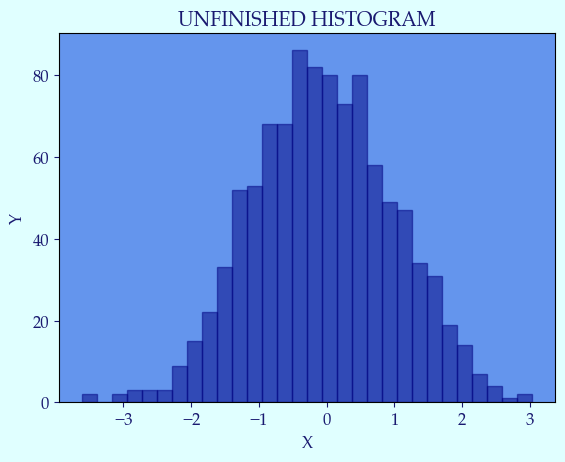

In [99]:

x = np.random.randn(1000)

fig, ax = plt.subplots()

ax.hist(data, bins=30, alpha = 0.5, color = "navy", edgecolor='navy')

# Set the background color of the axes
ax.set_facecolor('cornflowerblue')
fig.set_facecolor('lightcyan')

ax.set_title('UNFINISHED HISTOGRAM')
ax.set_xlabel('X')
ax.set_ylabel('Y')


plt.show()

#more customizing

plt.rcParams['text.color'] = 'midnightblue'
plt.rcParams['axes.labelcolor'] = 'midnightblue' # For axis labels
plt.rcParams['xtick.color'] = 'midnightblue'    # For x-axis tick labels
plt.rcParams['ytick.color'] = 'midnightblue'    # For y-axis tick labels

